In [15]:
import numpy as np 
import pandas as pd 
from glob import glob 
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
images_path = "/content/drive/MyDrive/MajorProject/Dataset/ImageCaptioning/Flickr/Flickr_Data/Images/"
images = glob(images_path+"*.jpg")
print(len(images))

8091


**Import Resnet 50**
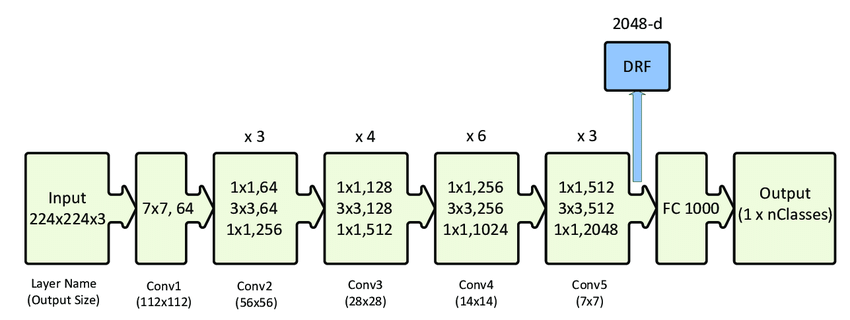

In [17]:
from  tensorflow.keras.applications import ResNet50

In [18]:
incept_model = ResNet50(include_top=True)

In [19]:
incept_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [20]:
from tensorflow.keras.models import Model 
last_layer = incept_model.layers[-2].output
res_net_model = Model(inputs=incept_model.input,outputs=last_layer)

In [21]:
res_net_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

Data Cleaning- Images

In [22]:
images_features = {}
count= 0
for image in images : 
    img = cv2.imread(image)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224))
    img = img.reshape(1,224,224,3)
    predict = res_net_model.predict(img).reshape(2048,)
    image_name = image.split("/")[-1]
    images_features[image_name] = predict
    count +=1
    if count>1700: 
        break
    elif count % 50 == 0:
        print(count)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700


In [23]:
#To verify size of output vector
IMG_F = {}
for image in images : 
    img = cv2.imread(image)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224))
    img = img.reshape(1,224,224,3)
    predict = res_net_model.predict(img).reshape(2048,)
    image_name = image.split("/")[-1]
    IMG_F[image_name] = predict
    print(predict)
    print(len(predict))
    break

[1.118554   1.0440533  0.         ... 0.         0.16263936 1.4577699 ]
2048


Data Cleaning- Captions

In [24]:
captions_path = "/content/drive/MyDrive/MajorProject/Dataset/ImageCaptioning/Flickr/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"

In [25]:
captions = pd.read_csv(captions_path,sep="\n",header=None)

In [26]:
captions = open(captions_path,"rb").read().decode('utf8').split("\n")

In [27]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [28]:
captions_dict = {}
for i in captions : 
    try : 
        img_name = i.split("\t")[0][:-2]
        caption  = i.split("\t")[1]
        if img_name in images_features: 
            if img_name not in captions_dict:
                # the case when the image name is not created yet
                captions_dict[img_name] = [caption]
            else : 
                # the case where the image name is created so we will juste append the new value knowing that there is 5 captions for every image
                captions_dict[img_name].append(caption)
    except:
        pass

In [29]:
def preprocessed(txt): 
    modified = txt.lower()
    modified = "startofseq" + modified + "endofseq"
    return modified

In [30]:
for k , v in captions_dict.items() : 
    for caption in v: 
        captions_dict[k][v.index(caption)] = preprocessed(caption)

Tokenization

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [32]:
tokenizer = Tokenizer(oov_token="Other")

In [33]:
sentences = []
for k,v in captions_dict.items():
    for sentence in v: 
        sentences.append(sentence)

In [34]:
tokenizer.fit_on_texts(sentences)

In [35]:
count_words = tokenizer.word_index

In [36]:
sequences =  tokenizer.texts_to_sequences(sentences)

In [37]:
sequences_images = {}
for k,v in captions_dict.items(): 
    sequences_images[k] = sequences[:5]
    sequences = sequences[5:]
    

In [38]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [39]:
sequences =  tokenizer.texts_to_sequences(sentences)

In [40]:
MAX_LEN = np.max([len(x) for x in sequences])
MAX_LEN

32

In [41]:
VOCAB_SIZE = len(count_words)
def generator (photo , caption ): 
    X = []
    y_in = []
    y_out = []
    for k , v in caption.items(): 
        for sentence in v : 
            for i in range(1,len(sentence)): 
#                 this for iterate every word in the sentence
                X.append(photo[k])
                in_seq = [sentence[:i]]
                out_seq = [sentence[i]]    
                in_seq = pad_sequences(in_seq,maxlen=MAX_LEN,padding ="post" ,truncating="post")[0]
                out_seq = to_categorical([out_seq],num_classes=VOCAB_SIZE+1)[0]
                y_in.append(in_seq)
                y_out.append(out_seq)
        
    return X, y_in,y_out

In [42]:
X,y_in,y_out = generator(images_features,sequences_images)

In [43]:
X,y_in,y_out = np.array(X),np.array(y_in),np.array(y_out)

In [44]:
X.shape,y_in.shape,y_out.shape

((91754, 2048), (91754, 32), (91754, 4640))

In [45]:
from tensorflow.keras.utils import to_categorical , plot_model 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint

In [46]:
MAX_LEN

32

Custom Model

In [47]:
embeding_size = 128
max_len = MAX_LEN
vocab_size = len(count_words) +1
image_model = Sequential()
image_model.add(Dense(embeding_size,input_shape = (2048,),activation="relu"))
image_model.add(RepeatVector(int(max_len)))
image_model.summary()

language_model = Sequential()
language_model.add(Embedding(input_dim=vocab_size,output_dim = embeding_size,input_length=max_len))
language_model.add( LSTM(256,return_sequences = True))
language_model.add(TimeDistributed(Dense(embeding_size)))
language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128,return_sequences = True)(conca)
x = LSTM(512,return_sequences = False)(x)
x = Dense(vocab_size)(x)
out = Activation("softmax")(x)
model = Model([image_model.input,language_model.input],outputs = out)
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 32, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 128)           593920    
                                                                 
 lstm (LSTM)                 (None, 32, 256)           394240    
                            

In [48]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 32)]         0           []                               
                                                                                                  
 dense_input (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 128)      593920      ['embedding_input[0][0]']        
                                                                                                  
 dense (Dense)                  (None, 128)          262272      ['dense_input[0][0]']            
                                                                                            

In [49]:
history = model.fit([X, y_in], y_out, batch_size=256, epochs=100)

Epoch 1/100
359/359 [==============================] - 43s 103ms/step - loss: 5.7257 - accuracy: 0.0878
Epoch 2/100
359/359 [==============================] - 38s 105ms/step - loss: 5.5952 - accuracy: 0.0869
Epoch 3/100
359/359 [==============================] - 38s 106ms/step - loss: 5.5890 - accuracy: 0.0884
Epoch 4/100
359/359 [==============================] - 38s 106ms/step - loss: 5.5846 - accuracy: 0.0875
Epoch 5/100
359/359 [==============================] - 38s 105ms/step - loss: 5.5815 - accuracy: 0.0870
Epoch 6/100
 58/359 [===>..........................] - ETA: 31s - loss: 5.5498 - accuracy: 0.0926

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/MajorProject/Dataset/ImageCaptioning/MODEL_1_RESNET_100_2.h5')

In [ ]:
def getImage(x): 
    test_img_path = images[x]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img, (224,224))
    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

In [ ]:
for i in range(5):
    # getting a random image
    no = np.random.randint(1500,7000,(1,1))[0,0]
    # extracting the features from the ResNet model
    test_feature = res_net_model.predict(getImage(no)).reshape(1,2048)
    
    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
        count += 1
        encoded = tokenizer.texts_to_sequences(text_inp)
        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max_len)
        prediction = np.argmax(model.predict([test_feature, encoded]))
        for k,v in tokenizer.word_index.items():
            if v == prediction:
                sampled_word = k
                break
                
                
        if sampled_word == 'endofseq':
            break
        caption = caption + ' ' + sampled_word
        
        text_inp[0] += ' ' + sampled_word
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)

Loading the model and testing

In [50]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/MajorProject/Dataset/ImageCaptioning/MODEL_1_RESNET_100.h5')

In [51]:
max_len = 32

In [52]:
def captionIT(path):    

    #path = '/content/temple.jpg'
    test_img_path = path
    test_img = cv2.imread(test_img_path, 1)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img, (224,224))
    test_img = np.reshape(test_img, (1,224,224,3))

    test_feature = res_net_model.predict(test_img).reshape(1,2048)
        
    test_img_path = path
    test_img = cv2.imread(test_img_path, 1)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    #sampled_word = 'endofseq'
    #sampled_word = 'e'

    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
      count += 1
      encoded = tokenizer.texts_to_sequences(text_inp)
      encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max_len)
      prediction = np.argmax(new_model.predict([test_feature, encoded]))
      for k,v in tokenizer.word_index.items():
          if v == prediction:
              sampled_word = k
              break              
      
      if sampled_word == 'endofseq':
        break
    
      caption = caption + ' ' + sampled_word
            
      text_inp[0] += ' ' + sampled_word
    
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)

    return caption

 beagle runs into the surf


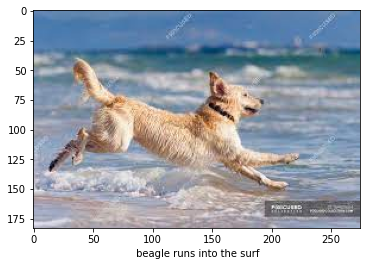

In [54]:
print(captionIT('/content/dog_2.jfif'))

 dog are sleeping next to a metal wide couch


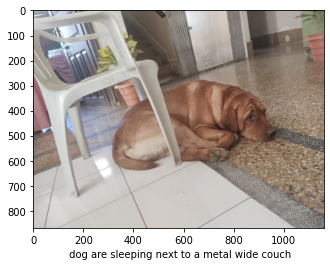

In [56]:
print(captionIT('/content/dog_4.jpeg'))

 two small small young bride are posing for a drink getting their group of a group of them


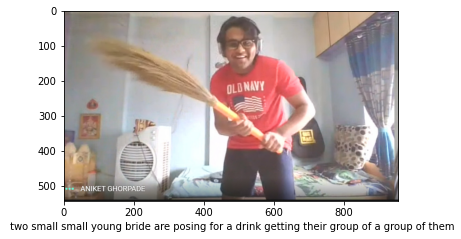

In [60]:
print(captionIT('/content/aniket_2.jpeg'))

 old little girl is pushing a colorful display at a carnival


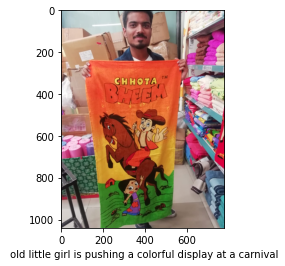

In [61]:
print(captionIT('/content/sanket_1.jpeg'))

In [ ]:
print(captionIT('/content/mountain.jfif'))

In [ ]:
print(captionIT('/content/sunset_beach.jfif'))

In [ ]:
print(captionIT('/content/cat_3.jpg'))

In [ ]:
print(captionIT('/content/tennis_1.jpg'))